# Prerequirements

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/kaggle/input/russia-real-estate-20182021/all_v2.csv")

In [3]:
df.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


# Feature engineering

#### There are no missing values in the dataset:

In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   price          5477006 non-null  int64  
 1   date           5477006 non-null  object 
 2   time           5477006 non-null  object 
 3   geo_lat        5477006 non-null  float64
 4   geo_lon        5477006 non-null  float64
 5   region         5477006 non-null  int64  
 6   building_type  5477006 non-null  int64  
 7   level          5477006 non-null  int64  
 8   levels         5477006 non-null  int64  
 9   rooms          5477006 non-null  int64  
 10  area           5477006 non-null  float64
 11  kitchen_area   5477006 non-null  float64
 12  object_type    5477006 non-null  int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


#### The dataset has 1523 duplicates. Considering data, it can't be different samples fith same features, so drop them:

In [5]:
print(f'Number of duplicates: {sum(df.duplicated())}')
df.drop_duplicates(inplace=True)

Number of duplicates: 1523


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,5475483.0,4.421478e+06,2.151016e+07,-2.144967e+09,1.950000e+06,2.990000e+06,4.800020e+06,2.147484e+09
geo_lat,5475483.0,5.403784e+01,4.622977e+00,4.145906e+01,5.337726e+01,5.517128e+01,5.622613e+01,7.198040e+01
geo_lon,5475483.0,5.324654e+01,2.074788e+01,1.989020e+01,3.777797e+01,4.307021e+01,6.564969e+01,1.625361e+02
region,5475483.0,4.307440e+03,3.307991e+03,3.000000e+00,2.661000e+03,2.922000e+03,6.171000e+03,6.188800e+04
building_type,5475483.0,1.949033e+00,1.038568e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
level,5475483.0,6.213816e+00,4.956792e+00,1.000000e+00,2.000000e+00,5.000000e+00,9.000000e+00,3.900000e+01
levels,5475483.0,1.139749e+01,6.534970e+00,1.000000e+00,5.000000e+00,1.000000e+01,1.600000e+01,3.900000e+01
rooms,5475483.0,1.726213e+00,1.082136e+00,-2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+01
area,5475483.0,5.391823e+01,3.335522e+01,7.000000e-02,3.800000e+01,4.802000e+01,6.313000e+01,7.856000e+03
kitchen_area,5475483.0,1.062817e+01,9.793369e+00,1.000000e-02,7.000000e+00,9.700000e+00,1.270000e+01,9.999000e+03


####  From above it can be seen that minimal price is negative, however it's not random value, it's just wrong minus. So make them all positive:

In [7]:
df['price'] = np.abs(df['price'])

#### Drop useless feature:

In [8]:
df.drop('time', axis=1, inplace=True)

#### There are 5% samples with number of rooms -2 or -1. Analyzing the median price, it can be concuded that it's one-room apartments:

In [9]:
print(f'Samples with number of rooms less or equal zero: {len(df[df["rooms"] <= 0]) / len(df) * 100} %')
print(f'Median price for such apartments: {np.median(df[df["rooms"] <= 0]["price"])}')
df['rooms'] = np.abs(df['rooms'])

Samples with number of rooms less or equal zero: 5.596839584745309 %
Median price for such apartments: 1890000.0


#### Remove some outliers:

In [10]:
df = df[(df['price'] >= 1e6) & (df['price'] <= 20e6)]
df = df[(df['area'] >= 20) & (df['area'] <= 300)]
df = df[(df['kitchen_area'] >= 5) & (df['kitchen_area'] <= 50)]

#### There are features representing the apartment floor and all floors in the building. I think it can be useful to create feature that looks like {floor/all_floors}, because usually, apartments on the first and last floors are cheaper. And I created a feature representing average room area:

In [11]:
df['level_ratio'] = df['level'] / df['levels']
df = df[df['level_ratio'] <= 1]
df['room_area'] = df['area'] / df['rooms']

#### Here we are not interested in precise date, it's better to divide this feature into month and year features:

In [12]:
df['year'] = df['date'].str.split('-').str[0].astype('int')
df['month'] = df['date'].str.split('-').str[1].astype('int')
df.drop('date', axis=1, inplace=True)

# Eploratory Data Analysis (EDA)

In [13]:
df

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,level_ratio,room_area,year,month
0,6050000,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1,0.800000,27.533333,2018,2
1,8650000,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1,0.208333,34.550000,2018,2
2,4000000,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1,0.555556,22.000000,2018,2
3,1850000,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11,0.750000,19.000000,2018,3
4,5450000,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1,0.928571,30.000000,2018,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477001,19739760,55.804736,37.750898,3,1,8,17,4,93.2,13.8,11,0.470588,23.300000,2021,5
5477002,12503160,55.841415,37.489624,3,2,17,32,2,45.9,6.6,11,0.531250,22.950000,2021,5
5477003,8800000,56.283909,44.075408,2871,2,4,17,3,86.5,11.8,1,0.235294,28.833333,2021,5
5477004,11831910,55.804736,37.750898,3,1,8,33,2,52.1,18.9,11,0.242424,26.050000,2021,5


#### Despite there are a few highly correlated features, there are no multicollinearity:

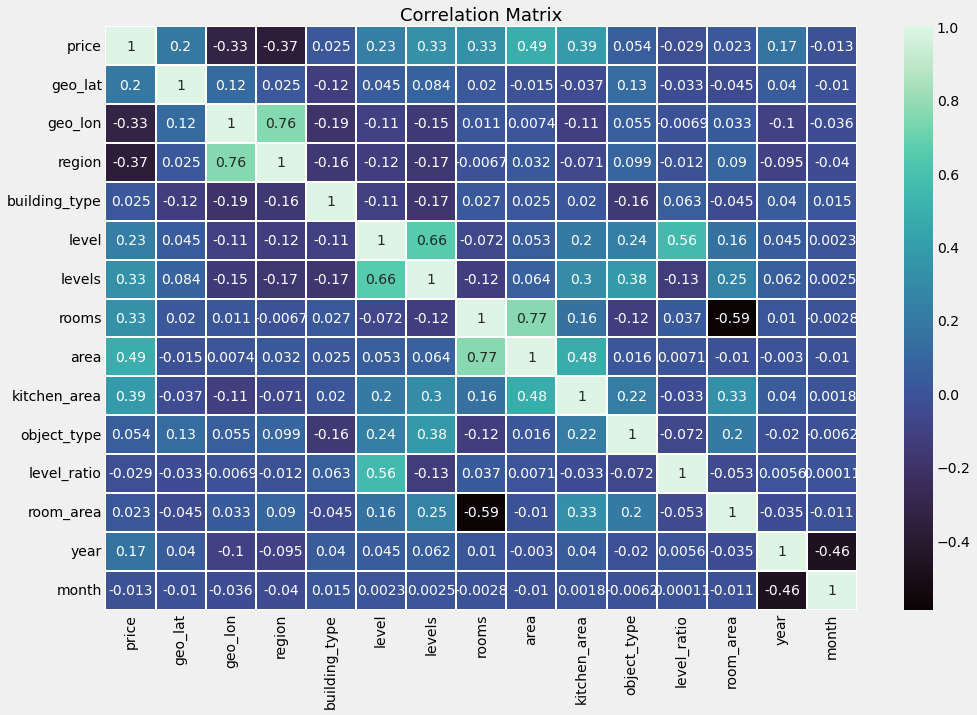

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), cmap='mako', linewidths=0.1, annot=True)
ax.set_title('Correlation Matrix', fontsize=18);

#### It's seen that the overwhelming majority is between 1,000,000 and 4,000,000 rubles; median is about 3,000,000 rubles:

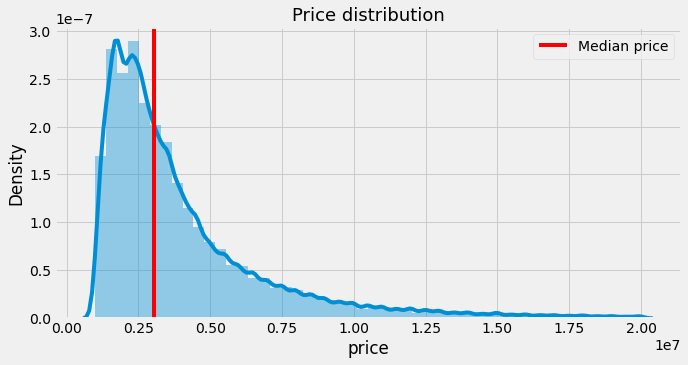

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df['price'])
plt.axvline(np.median(df['price']), label='Median price', color='red')
plt.legend()
ax.set_title('Price distribution', fontsize=18);

#### Distribution of other features:

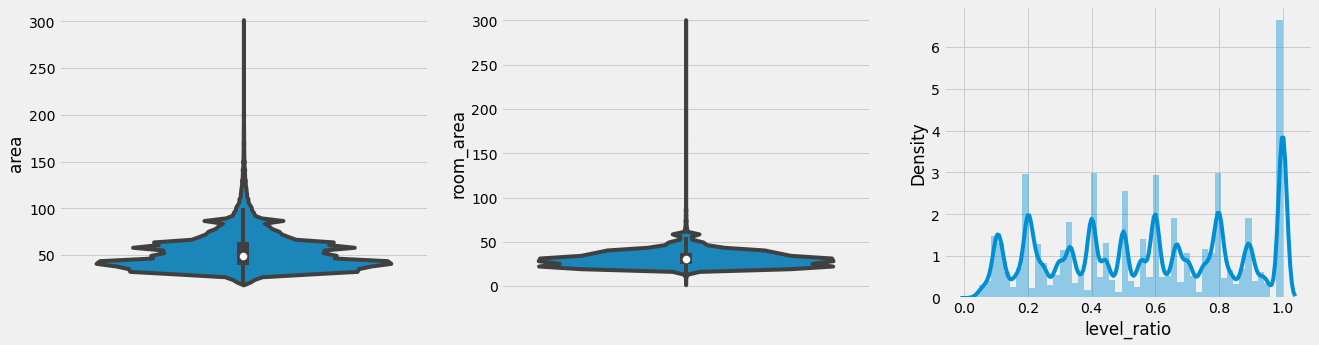

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.violinplot(y=df['area'], ax=ax[0])
sns.violinplot(y=df['room_area'], ax=ax[1])
sns.distplot(df['level_ratio'], ax=ax[2]);

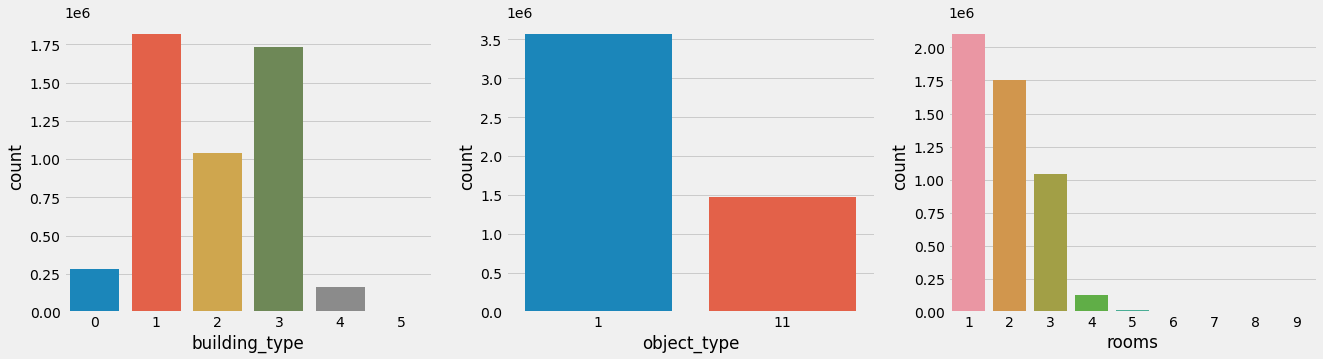

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.countplot(x=df['building_type'], ax=ax[0])
sns.countplot(x=df['object_type'], ax=ax[1])
sns.countplot(x=df['rooms'], ax=ax[2]);

# Predicting prices (regression)

#### Splitting the dataset into training and test in proportion 80/20. I dropped `region` feature, because prices differ too much in different regions:

In [18]:
x, y = df.drop(['price', 'region'], axis=1), df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

#### Training Gradient Boosting Regressor:

In [19]:
model = XGBRegressor(n_jobs=-1)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [20]:
print(f'R2-score of the model: {r2_score(model.predict(x_test), y_test)}')

R2-score of the model: 0.8808788564439627


#### Which features are most important according to XGBR:

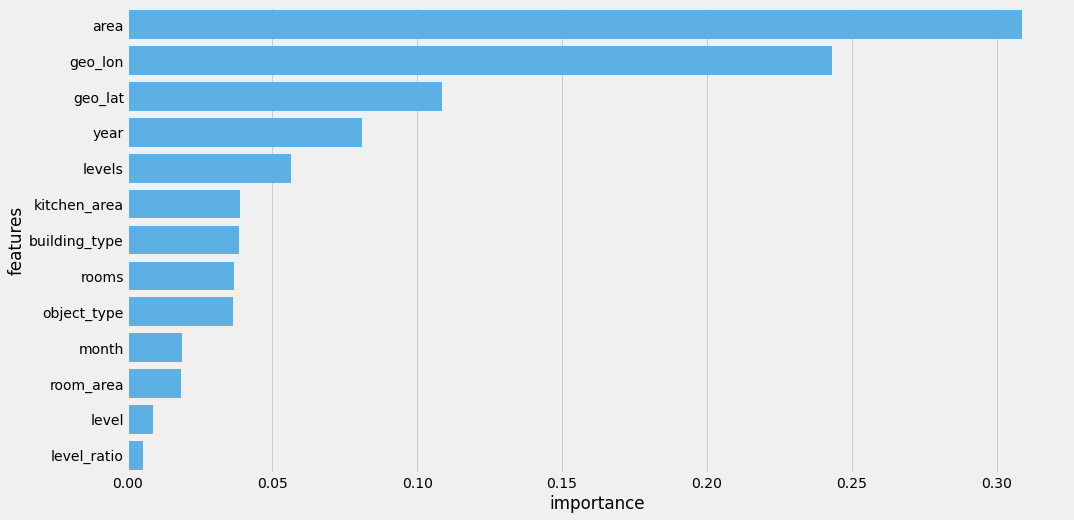

In [21]:
importance = pd.DataFrame({
    'features': x_train.columns,
    'importance': model.feature_importances_
})
importance = importance.sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(y='features', x='importance', data=importance, color='#46b5fa');

# Comparing with samples not from dataset 

#### Here I trained model on samples only from 81 region, which is actually Moscow, and from 2021. And test it on samples I manually collected from [web archive](https://web.archive.org/):

In [22]:
df = df[(df['region'] == 81) & (df['year'] == 2021)]
df.drop(['geo_lat', 'geo_lon', 'region', 'year', 'month'], axis=1, inplace=True)

In [23]:
df

,price,building_type,level,levels,rooms,area,kitchen_area,object_type,level_ratio,room_area
4910408,3400000,2,1,12,1,25.6,5.0,1,0.083333,25.600000
4910409,6400000,2,25,25,2,63.0,10.3,1,1.000000,31.500000
4910410,5300000,1,1,12,1,40.1,8.5,1,0.083333,40.100000
4910499,4700000,2,1,4,1,27.8,6.6,1,0.250000,27.800000
4910528,1470000,2,8,9,1,30.0,8.0,11,0.888889,30.000000
...,...,...,...,...,...,...,...,...,...,...
5476942,13100000,2,10,16,3,83.0,22.6,1,0.625000,27.666667
5476953,10650000,2,3,17,2,80.0,13.0,1,0.176471,40.000000
5476962,4339000,2,8,17,1,25.0,8.0,1,0.470588,25.000000
5476977,7293900,2,12,17,3,59.0,5.0,1,0.705882,19.666667


#### I used `GridSearchCV` to perform parameters tuning and find best ones for this case:

In [24]:
x, y = df.drop('price', axis=1), df['price']

In [25]:
params={
    "learning_rate": (0.05, 0.1, 0.2, 0.3, 0.4),
    "max_depth": [ 3, 4, 5, 6, 8],
    "min_child_weight": [ 1, 3, 5, 7],
    "gamma":[ 0.0, 0.1, 0.2],
    "colsample_bytree":[ 0.3, 0.4]
}

gr = GridSearchCV(estimator=XGBRegressor(n_jobs=-1),
                  param_grid=params,
                  cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=17),
                  scoring='r2',
                  n_jobs=-1)

gr.fit(x, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_c...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                  

In [26]:
print('The best parameters:')
gr.best_params_

The best parameters:


{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 1}

#### Predict prices of manually collected test dataset:

In [27]:
df_test = pd.read_csv("/kaggle/input/test-data/test_data.csv")

In [28]:
df_test

,price,building_type,level,levels,rooms,area,kitchen_area,object_type,level_ratio,room_area
0,9800000.0,2.0,22.0,30.0,2.0,60.0,12.3,11.0,0.733333,30.0
1,5000000.0,2.0,4.0,8.0,1.0,33.3,7.9,1.0,0.500000,33.3
2,5000000.0,3.0,3.0,10.0,1.0,35.0,9.0,1.0,0.300000,35.0
3,3850000.0,2.0,10.0,21.0,1.0,26.0,10.3,11.0,0.476190,26.0
4,6950000.0,2.0,7.0,15.0,2.0,42.2,5.0,11.0,0.466667,21.1
5,3700000.0,1.0,1.0,5.0,2.0,40.0,6.0,1.0,0.200000,20.0
6,3800000.0,1.0,4.0,4.0,2.0,48.0,10.0,1.0,1.000000,24.0
7,4900000.0,1.0,15.0,15.0,1.0,38.0,8.0,1.0,1.000000,38.0
8,6500000.0,1.0,15.0,25.0,1.0,37.0,12.0,11.0,0.600000,37.0
9,6900000.0,1.0,15.0,25.0,1.0,35.0,17.0,11.0,0.600000,35.0


In [29]:
pred = gr.best_estimator_.predict(df_test.drop('price', axis=1))

#### Column `diff` shows the difference between real price and predicted. They are distributed quite equally, there are samples with about 800,000 ruble difference wich is quite a lot, but still ok. However one sample's difference is very big, the model estimates it more that 2,000,000 rubles higher, it has the greatest area compared to other and area is the most valuable feature. It's difficult to say if model is bad or just in real life the apartment had some problems which are not represented in dataset (e.g. its condition, ceiling height, balcony):

In [30]:
df_res = pd.DataFrame({
    'real_prices': df_test['price'],
    'predicted_prices': pred
})

df_res['diff'] = df_res['real_prices'] - df_res['predicted_prices']
df_res

,real_prices,predicted_prices,diff
0,9800000.0,11931282.00,-2131282.00
1,5000000.0,5258401.00,-258401.00
2,5000000.0,4292611.50,707388.50
3,3850000.0,4087656.75,-237656.75
4,6950000.0,6735010.00,214990.00
5,3700000.0,3543339.25,156660.75
6,3800000.0,4512699.50,-712699.50
7,4900000.0,5703138.00,-803138.00
8,6500000.0,6355782.00,144218.00
9,6900000.0,6164922.50,735077.50
